# Invertible pipelines

## Recap

So far we learned:

1. how to implement a source dataset
2. how to transform the data
3. how to use data augmentation
4. how to optimize the pipelines via caching

These are the main ingredients that will help you train your model. Now what about deployment?

# Inverting the pipeline

In previous tutorials our dataset looked something like:

```python
dataset = Chain(
    source, 
    Binarize(),
    Zoom(factor=0.25),
    Crop(),
)
```

This means that your model will be trained on scaled and cropped images, hence it will expect (and make predictions for) scaled and cropped inputs at inference time. 

But the _user_ expects the predictions to be consistent with the _original_ input. So you need to pad and un-scale the prediction.
And while for two pre-processing steps this is not a big problem, for larger pipelines this starts to get tedious. 

But fear not, `connectome` got you covered! Let's modify our layers so that they can perform **inverse** operations.

## Un-cropping

In [1]:
from dpipe.im.box import mask2bounding_box
from dpipe.im import crop_to_box, pad
from connectome import Transform, inverse
import numpy as np

class Crop(Transform):
    def _box(image):
        return mask2bounding_box(image < 110)

    def image(image, _box):
        return crop_to_box(image, _box)

    def mask(mask, _box):
        return crop_to_box(mask, _box)

    # new transform:
    def _original_shape(image):
        return image.shape

    @inverse
    def probas(probas, _box, _original_shape):
        start = _box[0]
        stop = _original_shape - _box[1]
        padding = np.stack([start, stop], -1)
        return pad(probas, padding)

We have a new interesting function here - `probas` (we'll assume that our model returns probability maps instead of binary masks). It has the `inverse` decorator, which means that this an _inverse_ transformation. It takes the `probas` from the _next_ layer and passes it back to the _previous_ layer. Also, `inverse` functions have access to local parameters such as `_box` just like normal (or forward) functions.

This means that the `Crop` transform won't have a `probas` attribute:

In [2]:
crop = Crop()
dir(crop)

['image', 'mask']

# Using inverse transforms

If we don't have direct access to inverse functions how do we use them?

We already know, that pipelines don't necessarily need a `Source` layer. We can build pipelines that only consist of transform (or a single transform):

In [3]:
from layers02 import HeLa
from connectome import Chain

source = HeLa(root='DIC-C2DH-HeLa')
key = source.ids[0]
raw_x, raw_y = source.image(key), source.mask(key)

In [4]:
x, y = crop.image(raw_x), crop.mask(image=raw_x, mask=raw_y)

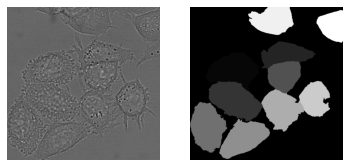

In [5]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.imshow(x, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(y, cmap='gray')
plt.axis('off');

Now let's create a very simple "segmentation" method - binary thresholding (read 'till the end for a more interesting example).

In [6]:
def predict(image):
    return (image > 140).astype(float)

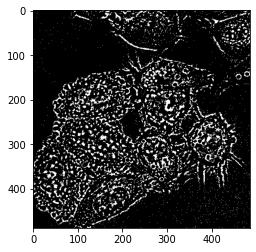

In [7]:
pred = predict(x)

plt.imshow(pred, cmap='gray')

So... it's not perfect, but we're keeping things simple here, remember?

Now, as you can see, the "prediction" is cropped just like the image. Let's modofy this function, and make it work with raw data:

In [8]:
@crop._decorate('image', 'probas')
def predict(image):
    return (image > 140).astype(float)

Each layer has a `_decorate` method, which is used (you guessed it) to decorate functions.
It takes a function, which is supposed to work with processed data, and makes it into one that works with raw data.

The first argument is the name of the field (or list of names) which the function takes as input. The second one - the field (or fields) that the function returns; this is where our `inverse` function "probas" kicks in.

Let's give it a try:

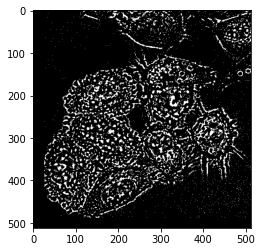

In [9]:
pred = predict(raw_x)

plt.imshow(pred, cmap='gray')

Magic, right?

## Un-scaling

Now let's do the same for other layers.

In [10]:
from skimage.transform import rescale, resize


class Zoom(Transform):
    _factor: float
    
    def image(image, _factor):
        return rescale(image.astype(float), _factor, order=1)
    
    def mask(mask, _factor):
        smooth = rescale(mask.astype(float), _factor, order=1)
        # the output will be a float ndarray, we need to convert it back to bool 
        return smooth >= 0.5
    
    def _original_shape(image):
        return image.shape
    
    @inverse
    def probas(probas, _original_shape):
        # scale back to the original shape
        return resize(probas, _original_shape, order=1)


class Binarize(Transform):
    # this layer does nothing to probas, so we'll just inherit them
    __inherit__ = 'image', 'probas'

    def mask(mask):
        return mask > 0

Now let's give it a try:

In [11]:
processing = Chain(
    Binarize(),
    Zoom(factor=0.25),
    Crop(),
)

@processing._decorate('image', 'probas')
def predict(image):
    return (image > 140).astype(float)

In [12]:
pred = predict(raw_x)
raw_x.shape, pred.shape

((512, 512), (512, 512))

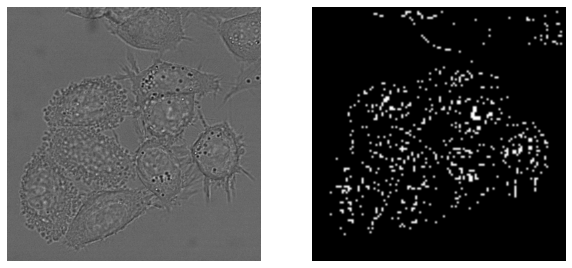

In [13]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(raw_x, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(pred, cmap='gray')
plt.axis('off');

The "segmentation" looks bad - this is an artifact caused by down- and then up- scaling the image. On the bright side, we have an end-to-end pipeline by writing a few additional `inverse` functions. No need to worry about correctly combining the pre- and post- processing, it's `connectome`'s job now!

# Bonus Chapter - Using a Neural Network

Now let's use something more interesting. We trained a netural network on this dataset specifically for this tutorial, so that you can get a glimpse on how a real end-to-end pipeline might look like.

First of all you'll need to download the model's weights from [here](https://drive.google.com/file/d/129XJZhbN66RWjl_Xr3WzguD1IPB7g-aj). Next let's initialize the model:

In [14]:
from dpipe import layers as lrs
from dpipe.torch import inference_step, load_model_state
import torch
from torch import nn

model = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=3, padding=1),
    
    lrs.FPN(
        lrs.ResBlock2d, nn.MaxPool2d(2), nn.Identity(),
        lrs.interpolate_merge(lambda x, y: torch.cat((x, y), 1), 1),
        [
            [[8, 8, 16], [32, 16, 16]],
            [[16, 16, 32], [64, 32, 16]],
            [[32, 32, 64], [128, 64, 32]],
            [[64, 64, 128], [256, 128, 64]],
            [128, 256, 128],
        ], 
        kernel_size=3, padding=1,
    ),
    
    lrs.PreActivation2d(16, 1, kernel_size=1),
)
# change the path to the weights, tif you want
load_model_state(model, 'model.pth')
# uncomment this, if you want to use a GPU
# model.to('cuda');

In [15]:
@processing._decorate('image', 'probas')
def predict(image):
    return inference_step(image[None, None].astype('float32'), architecture=model, activation=torch.sigmoid).squeeze((0, 1))

In [16]:
pred = predict(raw_x)
raw_x.shape, pred.shape

((512, 512), (512, 512))

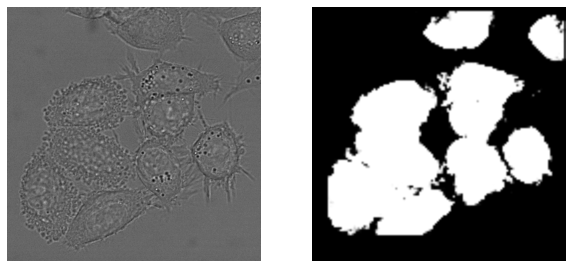

In [17]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(raw_x, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(pred, cmap='gray')
plt.axis('off');

Looks much better than global thresholding.